<!-- # Possible titles/angles -->
<!-- 1. inter-annual drivers of US east and Gulf Coast sea level (Steve, Jake, Anthony, Denis?) -->
## Connecting NAO, GS path variations, and coastal sea level along the USEC

# Introduction/Background

Many disparate analyses of internnual USEC variability and their drivers: 
1. Local forcing!
2. Valle-Levinson, McCarthy, Volkov, others link coastal sea level to remote NAO forcing: sometimes a single signed mode south of Hatteras, sometimes anti-phase N/S.
3. Wu and He -- SEUS sea level driven by connection to GS detachment SSH variability -- which is correlated with NAO.
4. Others (Andres/others) have noted a strong anticorrelation between N of Hatteras sea level and GS offshore.
5. Problem: superimposed modes that interfere. Definitely at shorter timescales, maybe at longer.
6. Wang papers have identified drivers and relevant forcing regions using B+M experiments, but always in relatively coarse model. Haven’t looked at details of alongcoast structure.
   * Sensitivity maps don’t show SSH in the GS path region.
   <!-- * because forcing is nonlocal but the path mediates. -->
   * Could be different because ECCO is coarse resolution.


Leaves questions:
1. Is NAO-associated sea level response a dipole, and what drives it? Does N/S coherence arise from dynamics or forcing? Remote or local?
2. What is the connection between large scale forcing (B+M), GS path migration, and coastal sea level? Are path migrations intrinsic, wind-forced, or is there a role for buoyancy, perhaps due to DWBC/slope current involvement?
3. Are results resolution-dependent?
 
<!-- * Little 24/25 points to notable differences at high rez. GRL paper focuses on a higher frequency mode. Here we remove the common mode and analyze what's left.
* By focusing on common spatial modes, lessen the effect of local errors. Also preserve alongcoast coherence. 
 -->
Here the goal is to:
1. consolidate various interpretations of structure and drivers
2. analyze the ability of these processes mode to be represented in global forced/coupled climate models.

## Import required packages, global parameters, functions

In [51]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
from scipy import signal
import scipy as sp
from scipy import io

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as xccrs
import cartopy.feature as cfeature
%matplotlib inline
import momlevel
import datetime as dt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from mypyutils import colormap_utils as mycolors
mdates.MonthLocator(bymonthday=15)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'serif',
    "font.serif": 'Computer Modern'
})    

cols=['k','C1','C0','C2','C3','C4','C5','C6']   
lines = ["-","--",":",":"]
panellabs=list(map(chr, range(97, 112)))
rotated_crs = xccrs.RotatedPole(pole_longitude=25.0, pole_latitude=70.0) # define projection!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("./../NSF-OCE_2148596/notebooks/pacific_HRDP_DPLE/lfca/Python")
from signal_processing import lfca

In [3]:
def tg_lfca(da, cutoff, truncation):
    lat_axis = da.tgindex.values
    time = da.time.values
    sst = da.to_numpy().squeeze()
    nlat = da.shape[1]
    ntime = da.shape[0]
    x = da.values
    area_weights = da[0, :] * 0 + 1
    area_weights = np.expand_dims(area_weights, axis=0)
    area_weights
    normvec = np.transpose(area_weights) / np.sum(area_weights)
    scale = np.sqrt(normvec)
    (
        lfcs,
        lfps,
        weights,
        r,
        pvar,
        pcs,
        eofs,
        ntr,
        pvar_slow,
        pvar_lfc,
        r_eofs,
        pvar_slow_eofs,
        lf_ts,
    ) = lfca(x, cutoff, truncation, scale)

    return lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts

In [4]:
def butter_bpfilt_high(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='high')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_band(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1, fc2], fs=fs, btype='band')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_low(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='low')
    return signal.filtfilt(b, a, x)
    
def filtfilt_bpbutter_2d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt    

def filtfilt_bpbutter_3d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["lat","lon","time"], [], [], [], []],  # regrid
        output_core_dims=[["lat","lon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

In [5]:
def detrend_linear2(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:,:]

def detrend_linear_tg(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:]
    
def detrend_deseason(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear2(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    # fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea
    fosi_desea=da.groupby("time.month")-fosi_mean_sea
    return fosi_desea.drop_vars('month'), fosi_trend

In [6]:
#processing functions

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    # print(x)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)
    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
        
    # print(x)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    # print(x,y)
    n     = x.shape[0]
    xmean = x.mean(axis=0, skipna=False)
    ymean = y.mean(axis=0, skipna=False)
    xstd  = x.std(axis=0, skipna=False)
    ystd  = y.std(axis=0, skipna=False)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    # pval   = t.sf(tstats, n-2)*2
    pval = t.sf(abs(tstats), n-2)*2 #corrected
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

## Import processed TGs and ALPACA output

In [7]:
tgs_in=pd.read_pickle("tgs_in_95_22.pkl") ##detrended
tgcsvin="./tgs_in_95_22.csv" #need to read in from csv for momlevel
tgnames=tgs_in['name2'].str.replace(r"\(.*\)","").str.replace(r"\,.*","").str.replace(r"\-.*","").str.replace(r"\/.*","").str.title()
shortname=tgnames.str.split('(').str[0]
shortname=shortname.str.split(',').str[0]
shortname

name
1701            Vaca Key
1858        Virginia Key
2123        Trident Pier
395         Fort Pulaski
234         Charleston I
396           Wilmington
2295            Beaufort
299        Sewells Point
1153            Cape May
12             New York 
1111    Nantucket Island
351              Newport
235               Boston
183           Portland  
Name: name2, dtype: object

In [8]:
xr_tg=xr.open_dataset('/glade/work/clittle/p2679/tgs_usec_95_22_USEC.nc') 
hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_usec_95_22.nc') 
lr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_lr_ssh_tgs_usec_95_22.nc') 
xr_tg=xr_tg.ssh
hr_tg=hr_tg.ssh-hr_tg.ssh.mean(dim='time')
hr_tg['time']=xr_tg.time
lr_tg=lr_tg.ssh-lr_tg.ssh.mean(dim='time')
lr_tg['time']=xr_tg.time
lr_tg=lr_tg.T
hr_tg=hr_tg.T

## Coastal/TG timeseries comparisons

/glade/derecho/scratch/clittle/tmp/ipykernel_86835/3695442294.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


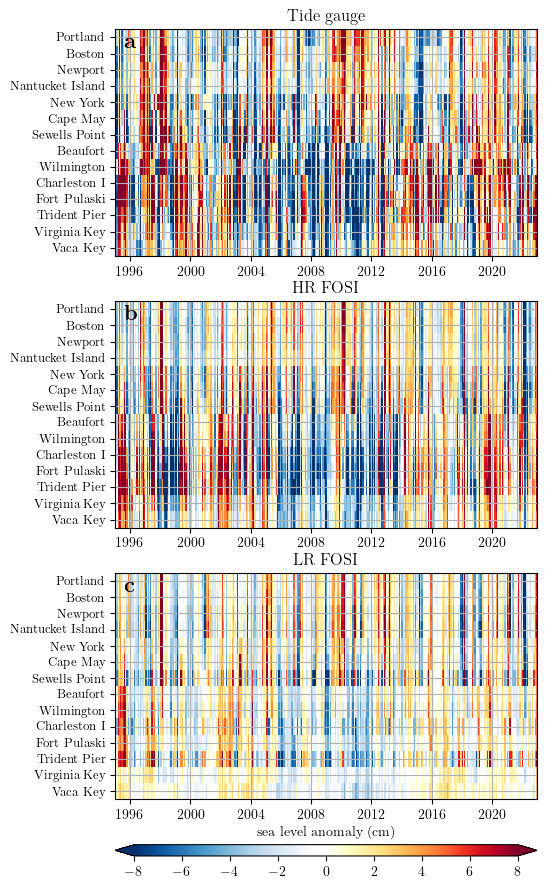

In [9]:
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(3):
    if nsim<1:
        plotvar=xr_tg
        titstr="Tide gauge"
    else:
        if nsim<2:
            plotvar=hr_tg
            titstr="HR FOSI"
        else:
            plotvar=lr_tg
            titstr="LR FOSI"

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.title(titstr)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)

/glade/derecho/scratch/clittle/tmp/ipykernel_86835/2725563618.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_86835/2725563618.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


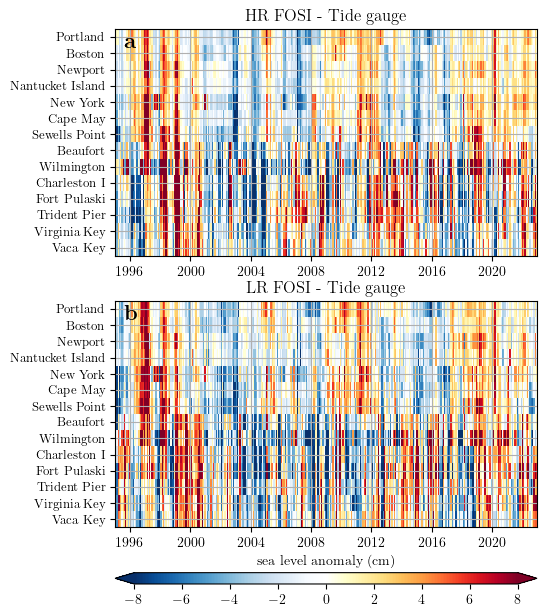

In [10]:
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(2):
    if nsim<1:
        plotvar=xr_tg-hr_tg
        titstr="HR FOSI - Tide gauge"
    else:
        if nsim<2:
            plotvar=xr_tg-lr_tg
            titstr="LR FOSI - Tide gauge"
        else:
            plotvar=lr_tg
            titstr="LR FOSI"

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.title(titstr)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>0:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)

## Calculate monthly EOFs and define plot fxns

In [11]:
def plot_pcs_m1(tgpcs,eofsin,expvar,expvar2,rec_eofs,vmaxin, varscale,nmode):
    fig = plt.figure(figsize=(15,15))#, tight_layout=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    cmap = 'plasma'
    cmap = mycolors.blue2red_cmap(20)
    ylabspacing = 2
    vmin = -vmaxin
    vmax = -vmin

    for nsim in np.arange(3):
        ax = plt.subplot2grid((5,3), (1, nsim), colspan=1, rowspan=2, projection=rotated_crs)#, aspect="auto")
        pos = ax.get_position() # get the original position 

        tt=rec_eof_ts[nsim][nmode,:,:]+xr_tg*0
        ccoef=xr.corr(tt,da_w_m1[nsim],'time')**2
        # if nmode<1:    
        #     VE=recs_m1[nsim].var(dim='time')/tot_var
        # else:
        #     if nmode<2:    
        #         VE=recs_m2[nsim].var(dim='time')/tot_var
        #     else:
        #         VE=recs_m3[nsim].var(dim='time')/tot_var
                
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=eofsin[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale*ccoef,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        for nkey in np.arange(2):
            varval=varscale*(.25+.5*nkey)
            
            varkey = plt.scatter(
                x=tgs_in.lon,
                y=tgs_in.lat,
                vmin=vmin,
                vmax=vmax,
                c=eofsin[nsim][nmode,:]*0,
                cmap=cmap,  # this is the changes
                s=varval,
                alpha=1,
                edgecolors=".6",
                linewidth=1,
                # marker=None,
                zorder=7,
                transform=xccrs.PlateCarree(),
            )  ## Important
            
            varkey.set_facecolor("none")   
        
        ax.set_extent([-90, -78, 20, 48], crs=xccrs.PlateCarree())        
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nmode<1:
            cbar_ax = fig.add_axes(
                [pos.x0+(pos.x1 - pos.x0)/4, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF (cm/SD)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
                
        # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
        # plt.figtext(-110,-40, "LF VE. = {:.0}".format(VE[nsp]), horizontalalignment='right', verticalalignment='center', fontsize=16, transform=ax.transAxes)
        # plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + 'EOF'+str(nmode+1), horizontalalignment='left', 
        plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + '', horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvar_eofs[nsim][nmode])+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=12, transform=ax.transAxes)

    # import matplotlib.dates as mdates
    ax = plt.subplot2grid((5,3), (3,0), colspan=3, rowspan=1)    
    for nsim in np.arange(3):
        line = ax.plot(xr_tg.time,tgpcs[nsim][:,nmode],cols[nsim], label = 'data')
    # line = ax.plot(xr_tg.time,gmsl_norm,cols[2], label = 'data')
        if nsim>0:
            tt=np.corrcoef(tgpcs[nsim][:,nmode],tgpcs[0][:,nmode])
            if nsim<2:
                ax.text(.25,.83, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C1')
            else:
                ax.text(.25,.73, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                transform=ax.transAxes, fontsize=14, weight='bold',color='C0') 
    plt.grid()
    plt.ylabel('Normalized PC')
    ax.legend([],     # The line objects
           labels=["TG PC1","HR PC1","LR PC1"],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
             )
    plt.figtext(0.02, .86, r"$\bf{" + panellabs[3] + '' "}$", horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)

In [12]:
kwargs = dict(n_modes=len(xr_tg.T)-1,random_state=2)#, normalize=True)
expvar_eofs=[]
expvar_lfcs=[]
expvar_lfcs2=[]
pcs=[]
eofs=[]
rec_eof_ts=[]
rec_lfp_ts=[]
da_w_m1=[]
lfcs=[]
lfps=[]
phases=[]
lf_tss=[]
# recvar=[]
# real_ts=[]
cuts=[36]
cutoff=cuts[0]
truncation=3
nmodes=truncation
rec_lfp=np.tile(xr_tg.values[np.newaxis,:, :]*0, [nmodes,1,1])
rec_eof=np.tile(xr_tg.values[np.newaxis,:, :]*0, [nmodes,1,1])
rec_var=rec_lfp[:,0,:]
rec_vars=[]

for nsim in np.arange(3):
    if nsim<1:
        dain=xr_tg
    else:
        if nsim<2:
            dain=hr_tg
        else:
            dain=lr_tg
            
    lfc, lfp, weights, r, pvar, pc, eof, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(dain, cutoff, truncation)
    expvar_lfc = pvar_slow #fraction of total SSH variance
    expvar_lfc2 = pvar_lfc #fraction of total SSH variance
    # lfp=lfp[np.argsort(-expvar_lfc),:]
    # lfc=lfc[:,np.argsort(-expvar_lfc)]
    # expvar_lfc=expvar_lfc[np.argsort(-expvar_lfc)]
    expvar_eof = pvar
    rec_eof=np.tile(xr_tg.values[np.newaxis,:, :]*0, [nmodes,1,1])
    
    for nmode in np.arange(nmodes):
        rec_eof[nmode,:,:]=np.outer(pc[:,nmode],eof[nmode,:])
        rec_lfp[nmode,:,:]=np.outer(lfc[:,nmode],lfp[nmode,:])
        # diag_pear_coef = [sp.stats.pearsonr(rec_lfp[nmode,:, i], lf_ts[:, i])[0] for i in range(rec_lfp.T.shape[0])]
        # diag_pear_coef = [sp.stats.pearsonr(rec_eof[nmode,:, i], dain[:, i])[0] for i in range(rec_lfp.T.shape[0])]
        # ve=(np.array(diag_pear_coef)) #**2)
        # rec_var[nmode,:]=ve
    
    da_w_m1.append(dain)
    expvar_eofs.append(expvar_eof)
    expvar_lfcs.append(expvar_lfc)
    expvar_lfcs2.append(expvar_lfc2)
    # real_ts.append(dain)
    rec_vars.append(rec_var)
    pcs.append(pc)
    lfcs.append(lfc)
    eofs.append(eof)
    lfps.append(lfp)
    lf_tss.append(lf_ts)
    rec_eof_ts.append(rec_eof)
    rec_lfp_ts.append(rec_lfp)

In [13]:
for nsim in np.arange(len(pcs)): 
    norm_fac=pcs[nsim][:,0].std()/pcs[0][:,0].std()
    print(norm_fac)
    # print(pcs[nsim][:,0])
    pcs[nsim][:,0]=pcs[nsim][:,0]/norm_fac
    # print(pcs[nsim][:,0])
    eofs[nsim][0,:]=eofs[nsim][0,:]*norm_fac

for nsim in np.arange(len(pcs)): 
    norm_fac=pcs[nsim][:,1].std()/pcs[0][:,1].std()
    print(norm_fac)
    # print(pcs[nsim][:,0])
    pcs[nsim][:,1]=pcs[nsim][:,1]/norm_fac
    # print(pcs[nsim][:,0])
    eofs[nsim][1,:]=eofs[nsim][1,:]*norm_fac

for nsim in [2]: 
    # total_var=real_ts[nsim].var(dim='time')
    # pcs[nsim][:,0]=-pcs[nsim][:,0]#/norm_fac
    # eofs[nsim][0,:]=-eofs[nsim][0,:]#*norm_fac
    pcs[nsim][:,1]=-pcs[nsim][:,1]#/norm_fac
    eofs[nsim][1,:]=-eofs[nsim][1,:]#*norm_fac
# eofs[nsim]=eofs[nsim].T

1.0
0.9353353073810484
0.58909361788806
1.0
0.8373295099951604
0.566635310754466


/glade/derecho/scratch/clittle/tmp/ipykernel_86835/1958070172.py:101: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


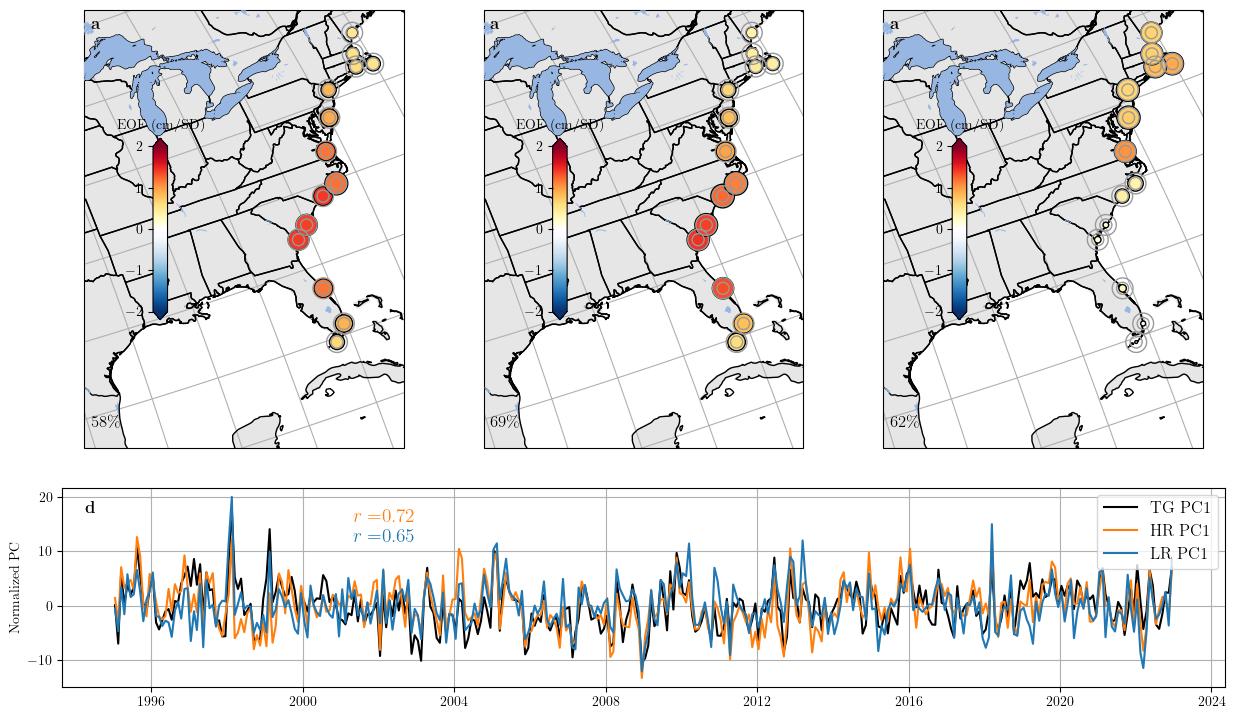

In [14]:
plot_pcs_m1(pcs,eofs,expvar_eofs,expvar_eofs,rec_eof_ts,2, 300,0 )#amps[nsim][0:2,:].max())
## limit to modes > 10% of LF. Or just #1 and #2.
## looking for coherent *non-linear* variability.

/glade/derecho/scratch/clittle/tmp/ipykernel_86835/1958070172.py:101: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


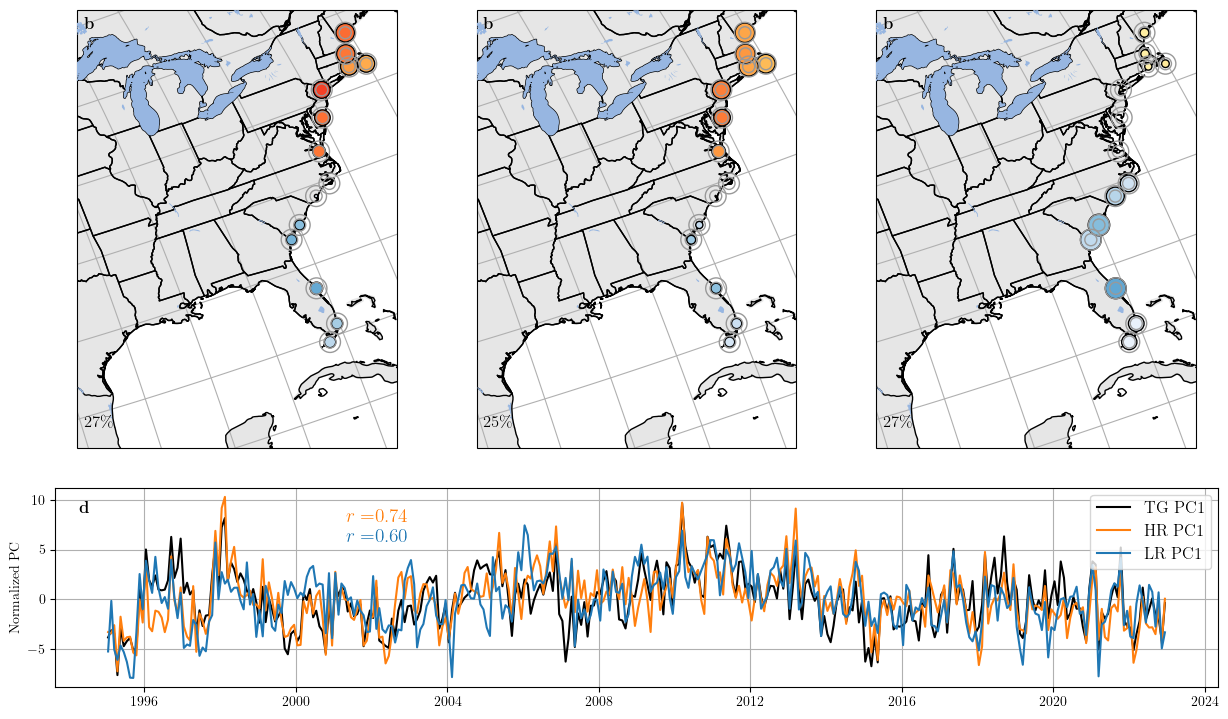

In [15]:
plot_pcs_m1(pcs,eofs,expvar_eofs,expvar_eofs,rec_eof_ts,2, 300,1)#amps[nsim][0:2,:].max())
## limit to modes > 10% of LF. Or just #1 and #2.
## looking for coherent *non-linear* variability.

## Altimetry analysis

In [16]:
datadir = '/glade/work/clittle/altimetry/MEASURES/monthly/'
alt=xr.open_mfdataset(datadir+'monthly*.nc')
alt=alt*100
alt=alt.rename({'Time': 'time','Longitude':'lon','Lon_bounds':'lon_b','Latitude':'lat','Lat_bounds':'lat_b'})
alt = alt.drop(['lon_b','lat_b'])
ds_alt=alt.sel(time=slice('1995-01-01', '2023-01-01'))
gmsl = xr.open_dataset("../NSF-OCE_2148596/notebooks/USEC_FOSI_rez_comp/gmsl_mo.nc")
gmsl=gmsl.sel(time=slice('1995-01-01', '2023-01-01'))#,Longitude=slice(xlo,xhi),Latitude=slice(ylo,yhi))
gmsl=gmsl.gmsl_variation/10

/glade/derecho/scratch/clittle/tmp/ipykernel_86835/56329713.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  alt = alt.drop(['lon_b','lat_b'])


In [17]:
xlo=1550; xhi=2200; ylo=550; yhi=900;
da=ds_alt.SLA-gmsl
da=da.isel(lon=slice(xlo,xhi),lat=slice(ylo,yhi))#.sel(time=slice('1993-01-01','2019-1-1'))
da['time']=xr_tg.time

In [18]:
[da_alt, datrend]=detrend_deseason(da.load())

In [19]:
pvalc=.05
ds_bathy = xr.open_dataset('/glade/work/clittle/p2521/input/'+"/obs/GEBCO.nc")

In [20]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_det.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
dahr=ssh

ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_det.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
dalr=ssh

da_ann=da_alt.rename({'lat':'TLAT','lon':'TLONG'}).groupby('time.year').mean('time').rename({'year':'time'})
dahr=dahr.groupby('time.year').mean('time').rename({'year':'time'})
dalr=dalr.groupby('time.year').mean('time').rename({'year':'time'})

## annual mean analysis

/glade/derecho/scratch/clittle/tmp/ipykernel_86835/252461750.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_86835/252461750.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_86835/252461750.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

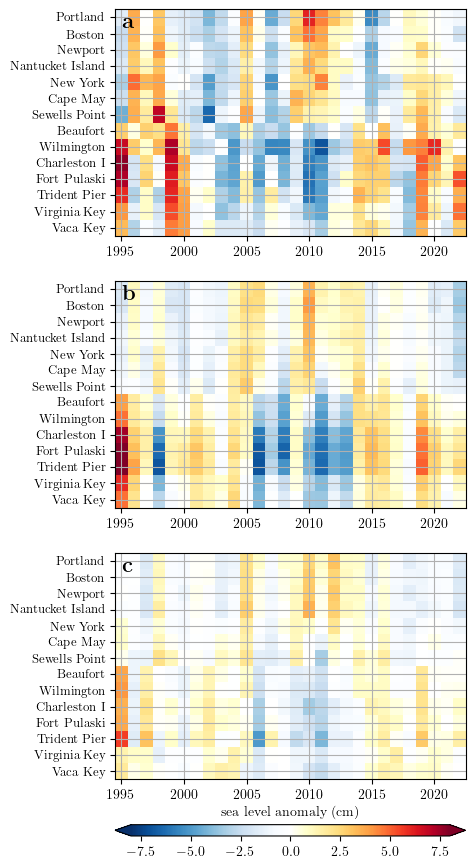

In [21]:
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 1
da_anns=[]
vmin = -8
vmax2 = -vmin

for ncol in np.arange(1):
    for nsim in np.arange(3):
        if ncol<1:
            plotvar=da_w_m1[nsim].groupby('time.year').mean('time').rename({'year':'time'})
            da_anns.append(plotvar)
        else:
            if ncol<2:
                da_rem_m1_ann=da_rem_m1[nsim].groupby('time.year').mean('time').rename({'year':'time'})
                plotvar=da_rem_m1_ann
                da_rem_m1_anns.append(plotvar)
            else:            
                plotvar=da_w_m1[nsim].groupby('time.year').mean('time').rename({'year':'time'})-rec_eof_ts[nsim][0,:,:].groupby('time.year').mean('time').rename({'year':'time'})  
            
        ax1 = plt.subplot2grid((3,6), (nsim, ncol*2), colspan=2, rowspan=1)
    
        filled1 = ax1.pcolormesh(
            plotvar.time,
            np.arange(0, len(tgnames), 1),
            plotvar.T,
            vmin=vmin,
            vmax=vmax2,
            cmap=cmap,
            shading="nearest",
        )
        plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                        verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
        # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
    # labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
    # ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
        ticks = np.arange(0, len(tgnames), ylabspacing)
        if nsim<5:
            labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
        else:
            labels = []
        ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
        # plt.title(titstr)
        plt.ylim([-.5, len(tgnames)-.5])
        plt.grid()
        pos = ax1.get_position()  # get the original position
        
        if nsim>1:
            cbar_ax = fig.add_axes(
                [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
            )
            cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
            cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
            

In [22]:
focustg1='234'
focustg2='234'
# after wang/lee

/glade/derecho/scratch/clittle/tmp/ipykernel_86835/4120372913.py:8: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


Text(0.4, 0.86, '$\\bf{Charleston I}$')

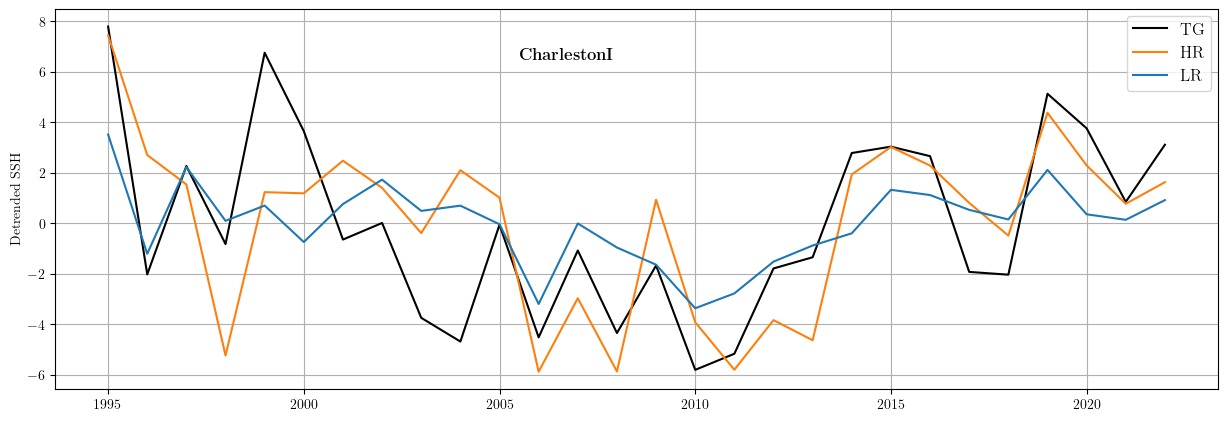

In [23]:
fig = plt.figure(figsize=(15,13))#, tight_layout=True)
ax = plt.subplot2grid((5,3), (3,0), colspan=3, rowspan=2)    
for nsim in np.arange(3):
    line = ax.plot(da_anns[nsim].time,da_anns[nsim].sel(tgindex=focustg2),cols[nsim], label = 'data')

plt.grid()
plt.ylabel('Detrended SSH')
ax.legend([],     # The line objects
       labels=["TG","HR","LR"],   # The labels for each line
       loc="upper right",   # Position of legend
       borderaxespad=0.4,    # Small spacing around legend box
       title="",
       fontsize=12,# Title for the legend
         )
plt.figtext(0.4, .86, r"$\bf{" + str(shortname[focustg2]) + '' "}$", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=12, transform=ax.transAxes)

In [24]:
nao=xr.open_dataset('nao.long.nc')
nao=nao.sel(time=slice('1994-12-31','2022-12-31'))
nao_am=nao.value.groupby('time.year').mean('time').rename({'year':'time'})
nao_am=-nao_am/nao_am.std(dim='time')

In [47]:
def plot_obs_pcs2b(tgpcs,eofsin,expvar,expvar2,rec_eofs,vmaxin, varscale,nmode):
    fig = plt.figure(figsize=(15,15))#, tight_layout=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    cmap = 'plasma'
    cmap = mycolors.blue2red_cmap(20)
    ylabspacing = 2
    
    vmin = -vmaxin
    vmax = -vmin
    # nmode=1
    for nsim in np.arange(3):
        ax = plt.subplot2grid((5,3), (1, nsim), colspan=1, rowspan=2, projection=rotated_crs)#, aspect="auto")
        pos = ax.get_position() # get the original position 

        tt=rec_eof_ts[nsim][nmode,:,:]+da_anns[nsim]*0
        ccoef=xr.corr(tt,da_anns[nsim])**2
        # if nmode<1:    
        #     VE=recs_m1[nsim].var(dim='time')/tot_var
        # else:
        #     if nmode<2:    
        #         VE=recs_m2[nsim].var(dim='time')/tot_var
        #     else:
        #         VE=recs_m3[nsim].var(dim='time')/tot_var
        if nsim>1:
            plotvar=-eofsin[nsim][nmode,:]
        else:
            plotvar=eofsin[nsim][nmode,:]
            
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=plotvar,
            cmap=cmap,  # this is the changes
            s=varscale*ccoef,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        for nkey in np.arange(2):
            varval=varscale*(.25+.5*nkey)
            
            varkey = plt.scatter(
                x=tgs_in.lon,
                y=tgs_in.lat,
                vmin=vmin,
                vmax=vmax,
                c=eofsin[nsim][nmode,:]*0,
                cmap=cmap,  # this is the changes
                s=varval,
                alpha=1,
                edgecolors=".6",
                linewidth=1,
                # marker=None,
                zorder=7,
                transform=xccrs.PlateCarree(),
            )  ## Important
            
            varkey.set_facecolor("none")   
        
        ax.set_extent([-90, -78, 20, 48], crs=xccrs.PlateCarree())        
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nmode<1:
            cbar_ax = fig.add_axes(
                [pos.x0+(pos.x1 - pos.x0)/4, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF (cm/SD)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
                
        # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
        # plt.figtext(-110,-40, "LF VE. = {:.0}".format(VE[nsp]), horizontalalignment='right', verticalalignment='center', fontsize=16, transform=ax.transAxes)
        # plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + 'EOF'+str(nmode+1), horizontalalignment='left', 
        plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + '', horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvar_eofs[nsim][nmode])+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
   

    # import matplotlib.dates as mdates
    ax = plt.subplot2grid((5,3), (3,0), colspan=3, rowspan=1)    
    for nsim in np.arange(3):
        if nsim>1:
            plotvar=-tgpcs[nsim][:,nmode]
        else:
            plotvar=tgpcs[nsim][:,nmode]
        line = ax.plot(da_anns[nsim].time,plotvar,cols[nsim], label = 'data')
        if nsim>0:
            tt=np.corrcoef(tgpcs[nsim][:,nmode],tgpcs[0][:,nmode])
            if nsim<2:
                ax.text(.25,.83, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                    transform=ax.transAxes, fontsize=14, weight='bold',color='C1')
            else:
                ax.text(.25,.73, '$r=$'+str('{0:.2f}'.format(tt[0,1])),#+', ',
                transform=ax.transAxes, fontsize=14, weight='bold',color='C0') 
                line = ax.plot(da_anns[nsim].time,nao_am,'k--')
    plt.grid()
    plt.ylabel('Normalized PC')
    ax.legend([],     # The line objects
           labels=["TG","HR","LR","NAO"],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
             )
    plt.figtext(0.02, .86, r"$\bf{" + panellabs[3] + '' "}$", horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)



In [48]:
kwargs = dict(n_modes=len(xr_tg.T)-1,random_state=2)#, normalize=True)
expvar_eofs=[]
expvar_lfcs=[]
expvar_lfcs2=[]
pcs=[]
eofs=[]
rec_eof_ts=[]
rec_lfp_ts=[]
# da_w_m1=[]
lfcs=[]
lfps=[]
phases=[]
lf_tss=[]
# recvar=[]
# real_ts=[]
cuts=[2]
cutoff=cuts[0]
truncation=6
nmodes=truncation
rec_lfp=np.tile(da_anns[nsim].values[np.newaxis,:, :]*0, [nmodes,1,1])
rec_var=rec_lfp[:,0,:]
rec_vars=[]
rec_eof=[]

for nsim in np.arange(3):
    dain=da_anns[nsim]
    # dain=da_w_m1[nsim].groupby('time.year').mean('time').rename({'year':'time'})-da_w_m1[0].groupby('time.year').mean('time').rename({'year':'time'})
            
    lfc, lfp, weights, r, pvar, pc, eof, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(dain, cutoff, truncation)
    expvar_lfc = pvar_slow #fraction of total SSH variance
    expvar_lfc2 = pvar_lfc #fraction of total SSH variance
    # lfp=lfp[np.argsort(-expvar_lfc),:]
    # lfc=lfc[:,np.argsort(-expvar_lfc)]
    # expvar_lfc=expvar_lfc[np.argsort(-expvar_lfc)]
    expvar_eof = pvar
    rec_eof=np.tile(da_anns[nsim].values[np.newaxis,:, :]*0, [nmodes,1,1])
    
    for nmode in np.arange(nmodes):
        rec_eof[nmode,:,:]=np.outer(pc[:,nmode],eof[nmode,:])
        rec_lfp[nmode,:,:]=np.outer(lfc[:,nmode],lfp[nmode,:])
        diag_pear_coef = [sp.stats.pearsonr(rec_lfp[nmode,:, i], lf_ts[:, i])[0] for i in range(rec_lfp.T.shape[0])]
        ve=(np.array(diag_pear_coef)) #**2)
        rec_var[nmode,:]=ve
    
    da_w_m1.append(dain)
    expvar_eofs.append(expvar_eof)
    expvar_lfcs.append(expvar_lfc)
    expvar_lfcs2.append(expvar_lfc2)
    # real_ts.append(dain)
    rec_vars.append(rec_var)
    pcs.append(pc)
    lfcs.append(lfc)
    eofs.append(eof)
    lfps.append(lfp)
    lf_tss.append(lf_ts)
    rec_eof_ts.append(rec_eof)
    rec_lfp_ts.append(rec_lfp)

In [49]:
for nsim in np.arange(len(pcs)): 
    # pcs[0][:,0]=pcs[0][:,0]/pcs[0][:,0].std()
    norm_fac=pcs[nsim][:,0].std()/pcs[0][:,0].std()
    print(norm_fac)
    # print(pcs[nsim][:,0])
    pcs[nsim][:,0]=pcs[nsim][:,0]/norm_fac
    # print(pcs[nsim][:,0])
    eofs[nsim][0,:]=eofs[nsim][0,:]*norm_fac

for nsim in np.arange(len(pcs)): 
    norm_fac=pcs[nsim][:,1].std()/pcs[0][:,1].std()
    print(norm_fac)
    # print(pcs[nsim][:,0])
    pcs[nsim][:,1]=pcs[nsim][:,1]/norm_fac
    # print(pcs[nsim][:,0])
    eofs[nsim][1,:]=eofs[nsim][1,:]*norm_fac

for nsim in [2]: 
    # total_var=real_ts[nsim].var(dim='time')
    pcs[nsim][:,0]=-pcs[nsim][:,0]#/norm_fac
    eofs[nsim][0,:]=-eofs[nsim][0,:]#*norm_fac
    pcs[nsim][:,1]=-pcs[nsim][:,1]#/norm_fac
    eofs[nsim][1,:]=-eofs[nsim][1,:]#*norm_fac
# eofs[nsim]=eofs[nsim].T

1.0
0.9698405212277752
0.48812482227562765
1.0
0.5812289588330083
0.4203187804972708


/glade/derecho/scratch/clittle/tmp/ipykernel_86835/2798327287.py:111: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


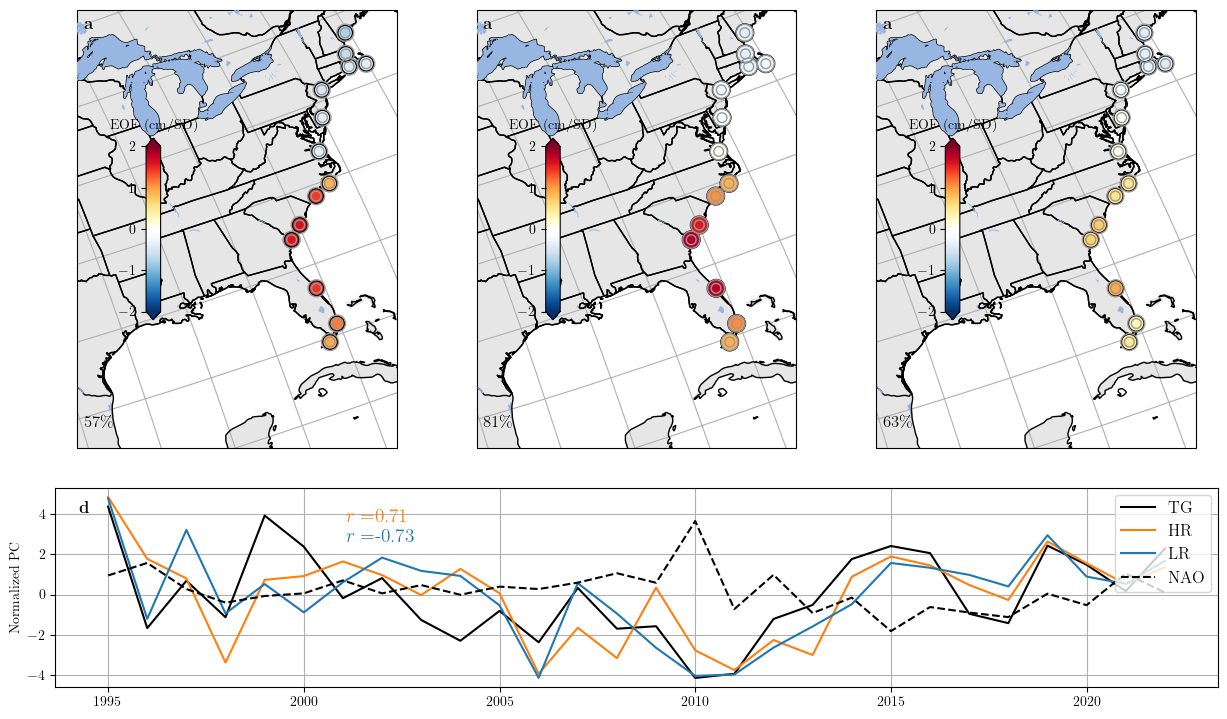

In [50]:
plot_obs_pcs2b(pcs,eofs,expvar_eofs,expvar_eofs,rec_eof_ts,2, 200, 0)#amps[nsim][0:2,:].max())

* annual mean leading EOFS

/glade/derecho/scratch/clittle/tmp/ipykernel_86835/2549766216.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


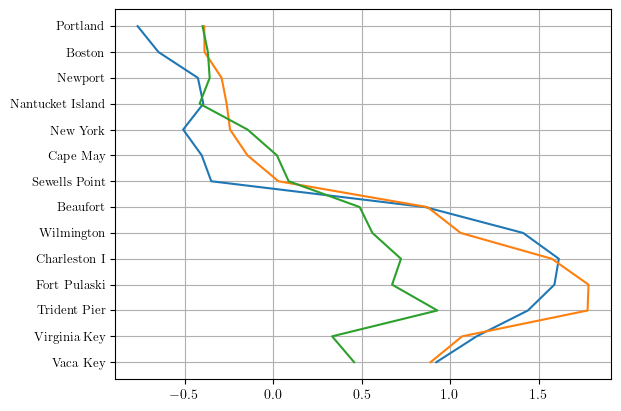

In [29]:
ax = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1)    
plt.plot(eofs[0][0,:],np.arange(len(tgnames)))
plt.plot(eofs[1][0,:],np.arange(len(tgnames)))
plt.plot(-eofs[2][0,:],np.arange(len(tgnames)))
# plt.plot(eofs[1][0,:])
# plt.plot(-eofs[2][0,:])
# plt.plot(eofs[2][:,0]-eofs[0][:,0])
ticks = np.arange(0, len(tgnames), ylabspacing)
labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
ax.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
plt.grid()


In [36]:
def plot_ssh_reg2(tgpcs,SSH,tglons,tglats, lagx, coast_reg=True):
    fig = plt.figure(figsize=(18,12), tight_layout=True)
    vmin=-2
    vmax=-vmin
    
    cmap = mycolors.blue2red_cmap(20)
    
    for nsp in [0]:#np.arange(1):
        # for nsim in np.arange(3):#[1,2]:# #:#
        for nsim in np.arange(2)+1:#[1,2]:# #:#
            pc2=tgpcs[nsim].T
            if nsim>1:
                pc2=-pc2
            # lagx=0
            lons=SSH[nsim].TLONG.fillna(0)
            lats=SSH[nsim].TLAT.fillna(0)
            tgpcs=tgpcs
            regressand=SSH[nsim] 
            # regressand2=xr_tg.TG_IB_CORR
                    
            focusts=regressand[:,0,0].fillna(0)*0+np.real(pc2[nsp,:])
            cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=focusts,y=regressand, lagx=lagx)
            altrc=slope+regressand[0,:,:]*0
            altpval=pval
            mask=1+0/(pval<pvalc)
            # focusts=regressand2.isel(tgindex=0).squeeze()*0+np.real(tgpcs[nsp,:])
            # cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=focusts,y=regressand2, lagx=lagx)
            
            ax = plt.subplot2grid((1,3), (0, nsim), colspan=1, rowspan=1, projection=xccrs.PlateCarree())#, aspect="auto")
            
            pos = ax.get_position() # get the original position 
            if coast_reg:
                ax.set_extent([-83, -60, 20, 52], crs=xccrs.PlateCarree())
            else:
                ax.set_extent([-100, 0, 10, 70], crs=xccrs.PlateCarree())
            sign=np.sign(mask*altrc)
            # im = ax.pcolormesh(lons, lats, sign*np.log10(np.abs(mask*altrc)), shading='nearest', vmin=vmin, vmax=vmax, 
            im = ax.pcolormesh(lons, lats, mask*altrc, shading='nearest', vmin=vmin, vmax=vmax, 
            # im = ax.pcolormesh(lons, lats, altrc, shading='nearest', vmin=vmin, vmax=vmax, 
                        cmap=cmap,zorder=1,transform=xccrs.PlateCarree())    

            CS2 = ax.contour(ds_bathy.depth.longitude ,ds_bathy.depth.latitude, -ds_bathy.depth,
                            np.arange(100,101,1),colors='.6',linewidths=2,zorder=2,transform=xccrs.PlateCarree())
            
            CS2 = ax.contour(ds_bathy.depth.longitude ,ds_bathy.depth.latitude, -ds_bathy.depth,
                           np.arange(1000,2000,1000),colors='.6',linewidths=1,zorder=2,transform=xccrs.PlateCarree())

            if nsp==0:
                cbar_ax = fig.add_axes(
                    [pos.x1-(pos.x1 - pos.x0)/10, pos.y0+(pos.y1 - pos.y0)/10, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
                )
                cbar = fig.colorbar(im, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
                # cbar.ax.set_title("Reg. Coef. on PC" + str(nmode+1), rotation=0, size=10, weight="bold")
                cbar.ax.tick_params(labelsize=10)
                
            # if nsim<1:
            #     plt.figtext(.05, .95, 'Regression on HR PC'+str(nsp+1), horizontalalignment='left', verticalalignment='center', fontsize=20, transform=ax.transAxes)
            # else:
            #     plt.figtext(.05, .95, 'Regression on LR PC'+str(nsp+1), horizontalalignment='left', verticalalignment='center', fontsize=20, transform=ax.transAxes)
                            
            ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
            # ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
    
            ax.coastlines(zorder=5)
            ax.gridlines()
            # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
    # return altrc

In [32]:
# IF NO REMOVAL!!

da_ann=da_alt.groupby('time.year').mean('time').rename({'year':'time'}).rename({'lat':'TLAT','lon':'TLONG'})
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_det.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
ssh['time']=da_alt.time
# ssh=ssh.rename({'nlat':'lat','nlon':'lon'})

dahr=ssh.groupby('time.year').mean('time').rename({'year':'time'})#
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_det.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
# ssh=ssh.rename({'nlat':'lat','nlon':'lon'})

ssh['time']=da_alt.time
dalr=ssh.groupby('time.year').mean('time').rename({'year':'time'})

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


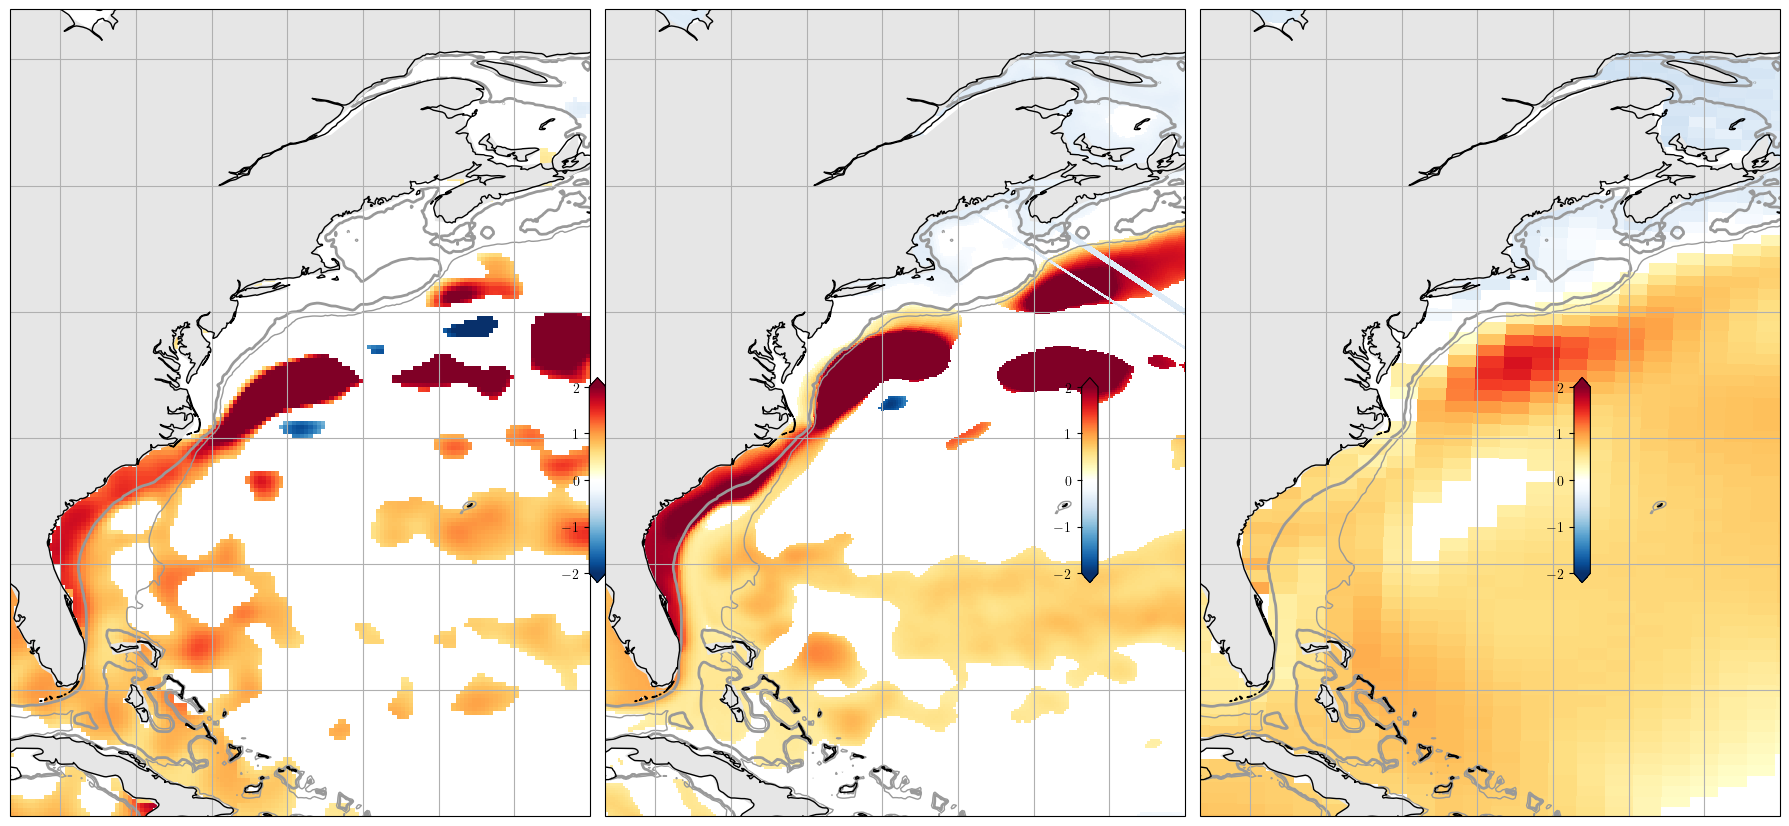

In [33]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, True)

* regression on annual mean leading EOFS

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


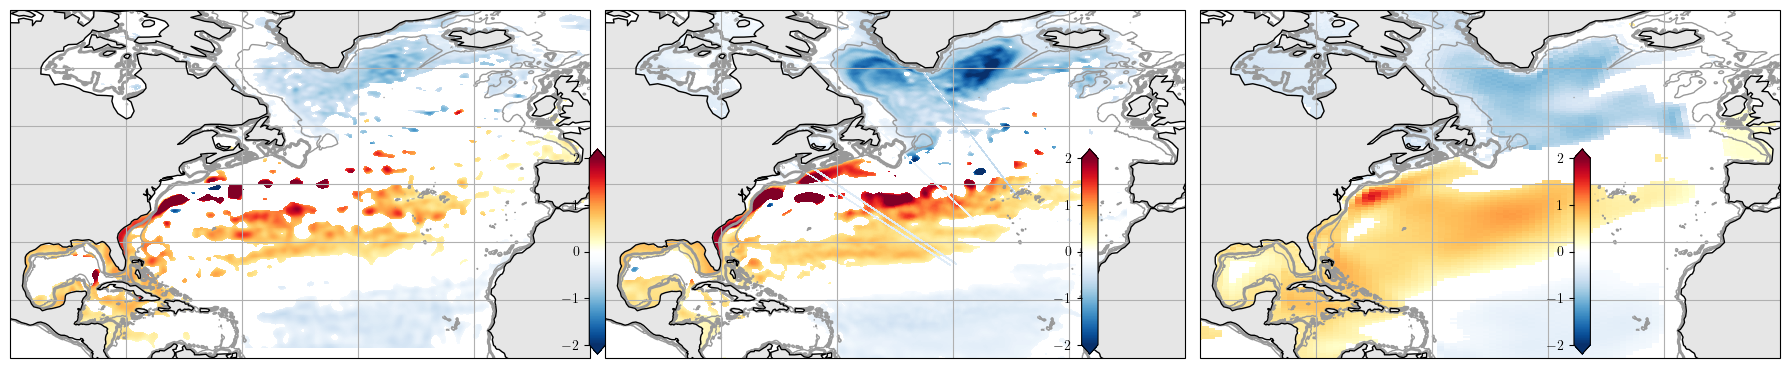

In [102]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, False)

## Regression of full simulation mode 1 on Buoyancy-forced SSH

In [37]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_b_det.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
ssh['time']=da_alt.time
# ssh=ssh.rename({'nlat':'lat','nlon':'lon'})

dahr=ssh.groupby('time.year').mean('time').rename({'year':'time'})#

ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_b_det.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
# ssh=ssh.rename({'nlat':'lat','nlon':'lon'})

ssh['time']=da_alt.time
dalr=ssh.groupby('time.year').mean('time').rename({'year':'time'})

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


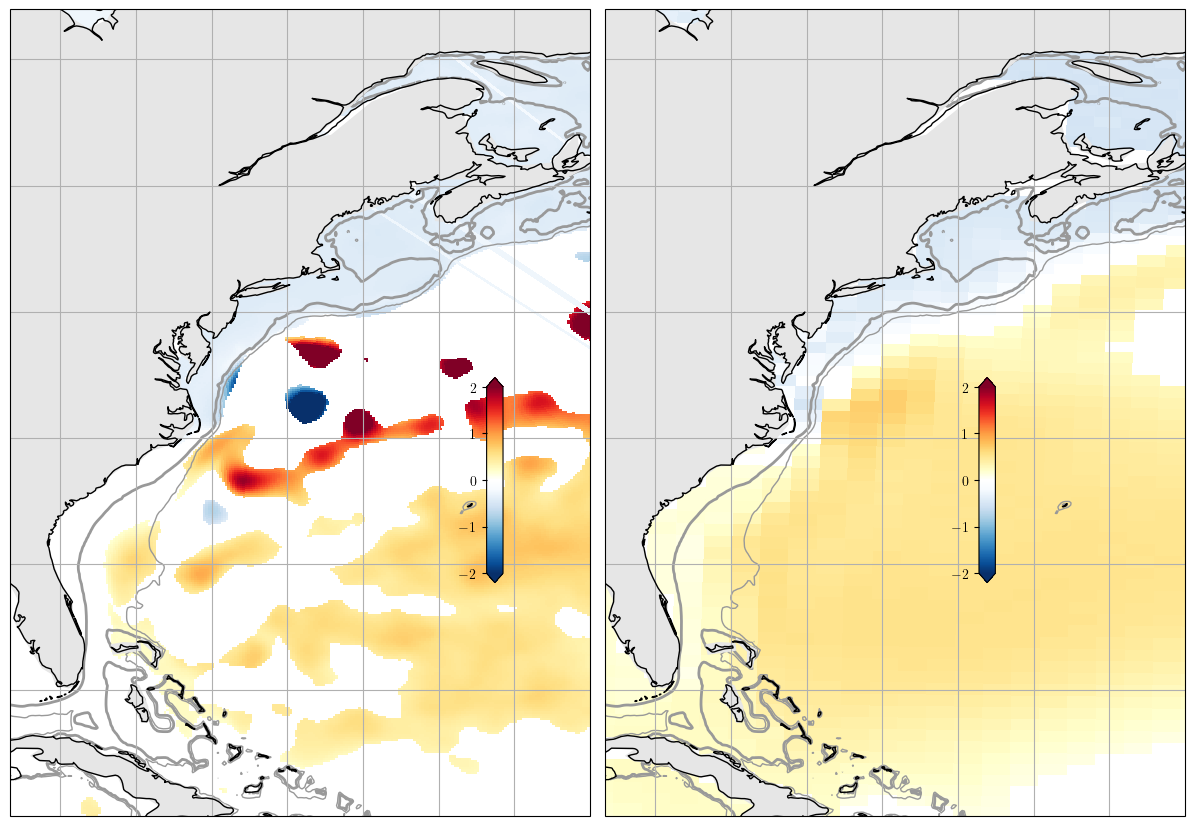

In [38]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, True)

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


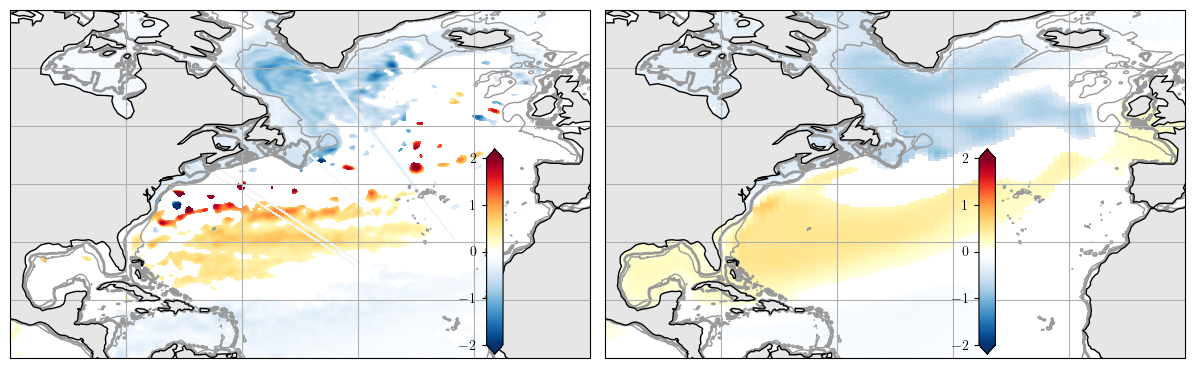

In [39]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, False)

## Regression of full simulation mode 1 on Momentum-forced SSH

In [40]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_m-r_det.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
ssh['time']=da_alt.time
# ssh=ssh.rename({'nlat':'lat','nlon':'lon'})

dahr=ssh.groupby('time.year').mean('time').rename({'year':'time'})#

ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_m-r_det.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
# ssh=ssh.rename({'nlat':'lat','nlon':'lon'})

ssh['time']=da_alt.time
dalr=ssh.groupby('time.year').mean('time').rename({'year':'time'})

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


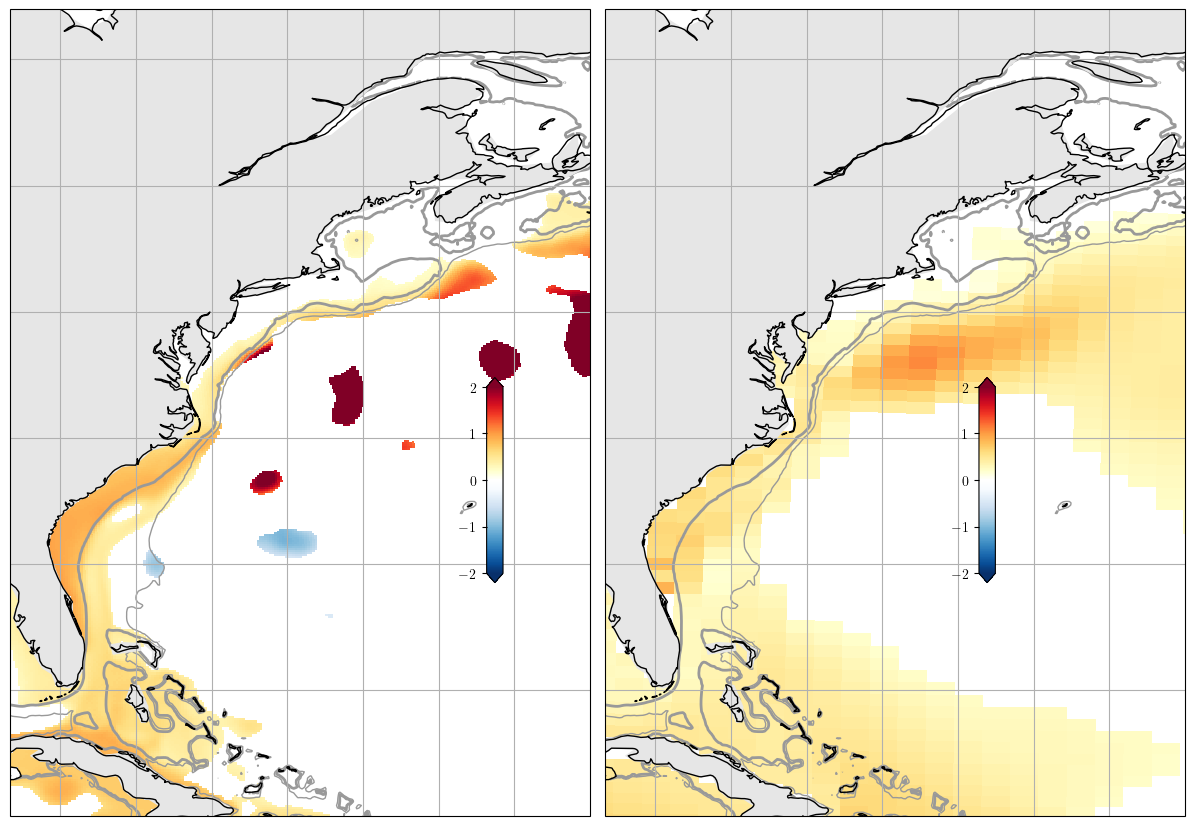

In [41]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, True)

* weak penetration of momentum forced signal N of hatteras in HR.
* More penetration in LR, which partially offsets buoyancy forced signal north of Hatteras and enhances south
* Limited evidence for coherent offshore anomaly.
* coherence with caribbean sea (also evident in LR)

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


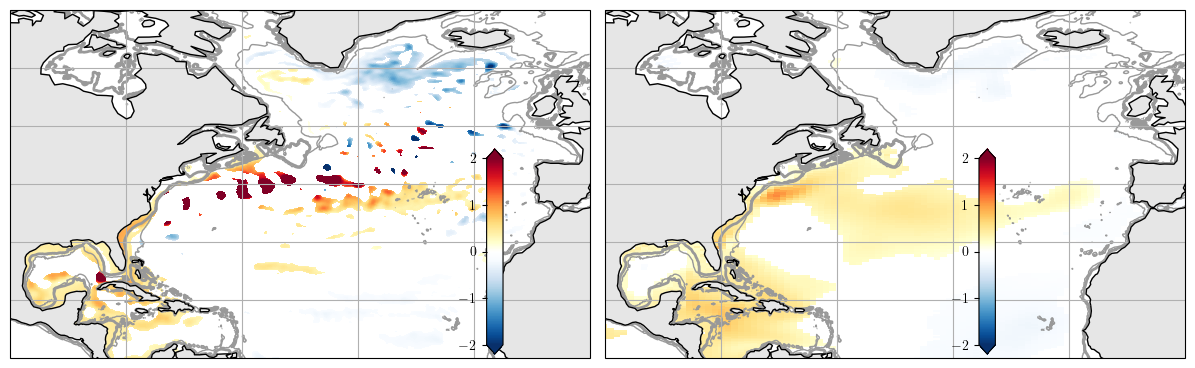

In [42]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, False)

## Regression of full simulation mode 1 on Residual (Full-M-RYF-B)

In [43]:
ssh1 = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_det.nc')
ssh2 = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_b_det.nc')
ssh3 = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_m-r_det.nc')
ssh=ssh1-ssh2-ssh3
ssh=ssh.ssh.isel(time=slice(24,336+24))
ssh['time']=da_alt.time
# ssh=ssh.rename({'nlat':'lat','nlon':'lon'})

dahr=ssh.groupby('time.year').mean('time').rename({'year':'time'})#

ssh1 = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_det.nc')
ssh1=ssh1.ssh.isel(time=slice(24,336+24))
ssh1['time']=da_alt.time
ssh2 = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_b_det.nc')
ssh2=ssh2.ssh.isel(time=slice(24,336+24))
ssh2['time']=da_alt.time
ssh3 = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_m-r_det.nc')
ssh3=ssh3.ssh.isel(time=slice(24,336+24))
ssh3['time']=da_alt.time
ssh=ssh1-ssh2-ssh3
dalr=ssh.groupby('time.year').mean('time').rename({'year':'time'})

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


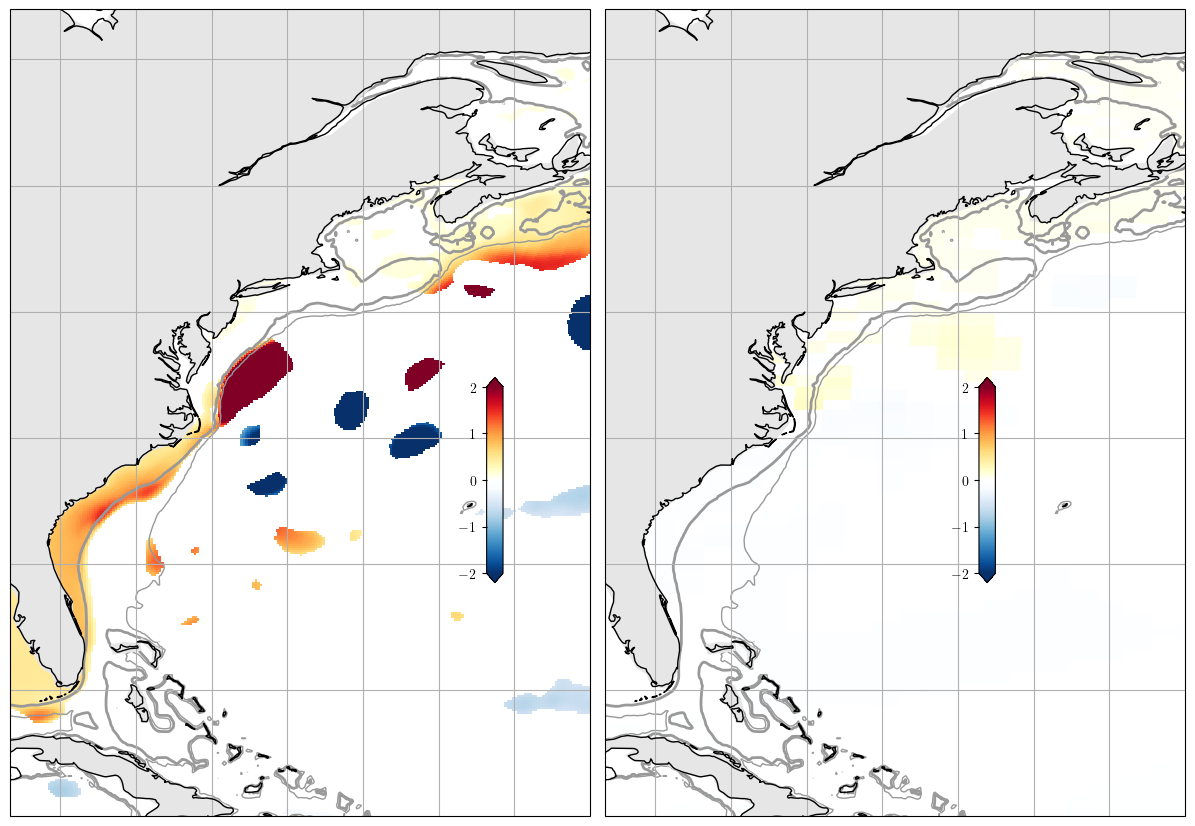

In [44]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, True)

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


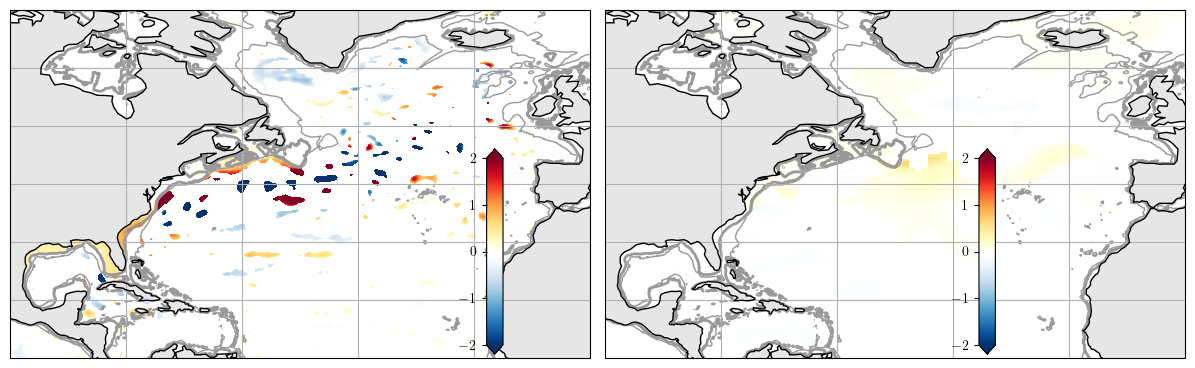

In [45]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, False)

In [92]:
hr_m_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_m-r_det.nc')
# hr_m_tg=hr_m_tg.isel(time=slice(24,24+336))
hr_b_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_b_det.nc')
# hr_b_tg=hr_b_tg.isel(time=slice(24,24+336))

hr_m_tg=hr_m_tg.ssh-hr_m_tg.ssh.mean(dim='time')
hr_m_tg['time']=xr_tg.time
hr_b_tg=hr_b_tg.ssh-hr_b_tg.ssh.mean(dim='time')
hr_b_tg['time']=xr_tg.time
hr_b_tg=hr_b_tg.groupby('time.year').mean('time').rename({'year':'time'})
hr_m_tg=hr_m_tg.groupby('time.year').mean('time').rename({'year':'time'})
hr_tg=da_anns[1]

In [93]:
lr_m_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_lr_ssh_tgs_m-r_det.nc')
lr_b_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_lr_ssh_tgs_b_det.nc')

lr_m_tg=lr_m_tg.ssh-lr_m_tg.ssh.mean(dim='time')
lr_m_tg['time']=xr_tg.time
lr_b_tg=lr_b_tg.ssh-lr_b_tg.ssh.mean(dim='time')
lr_b_tg['time']=xr_tg.time
lr_b_tg=lr_b_tg.groupby('time.year').mean('time').rename({'year':'time'})
lr_m_tg=lr_m_tg.groupby('time.year').mean('time').rename({'year':'time'})
lr_tg=da_anns[2]

/glade/derecho/scratch/clittle/tmp/ipykernel_55388/3172764241.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_55388/3172764241.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((4,3), (nsim, 1), colspan=2, rowspan=1)


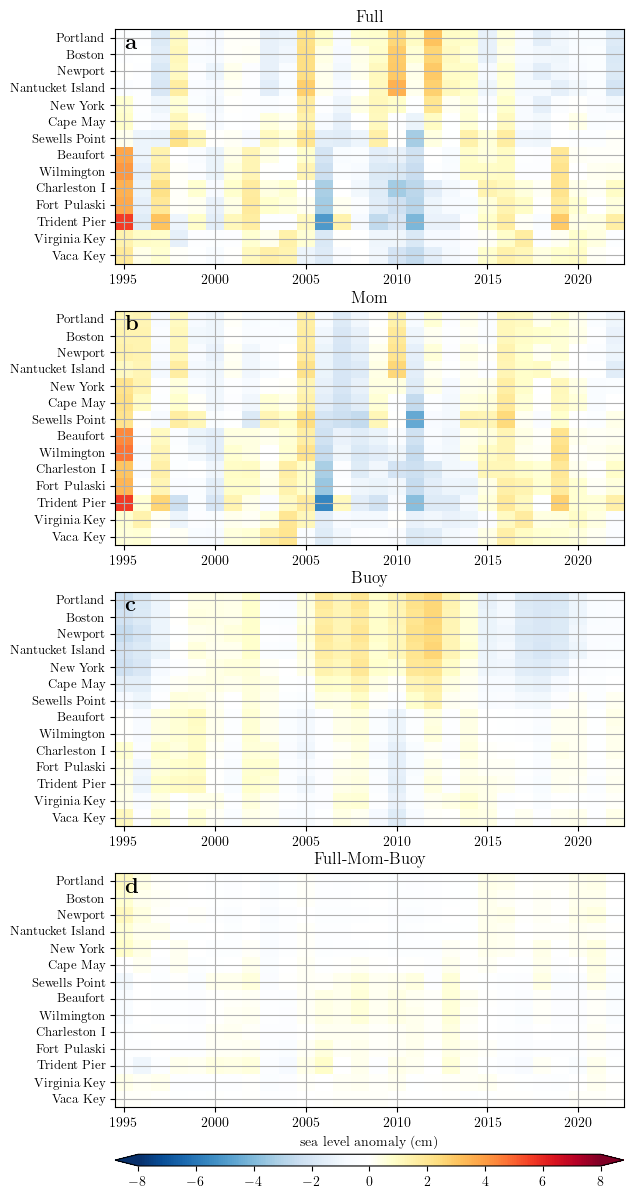

In [96]:
fig = plt.figure(figsize=(10,14))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(4):
    if nsim<1:
        plotvar=lr_tg
        titstr="Full"
    else:
        if nsim<2:
            plotvar=lr_m_tg.T
            titstr="Mom"
        else:
            if nsim<3:
                plotvar=lr_b_tg.T
                titstr="Buoy"
            else:
                plotvar=(lr_tg.T-lr_m_tg-lr_b_tg).T
                titstr="Full-Mom-Buoy"

    ax1 = plt.subplot2grid((4,3), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        lr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    plt.title(titstr)
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)
plt.savefig('USEC_M_B_timeseries.png',
)

/glade/derecho/scratch/clittle/tmp/ipykernel_55388/972130413.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_55388/972130413.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((4,3), (nsim, 1), colspan=2, rowspan=1)


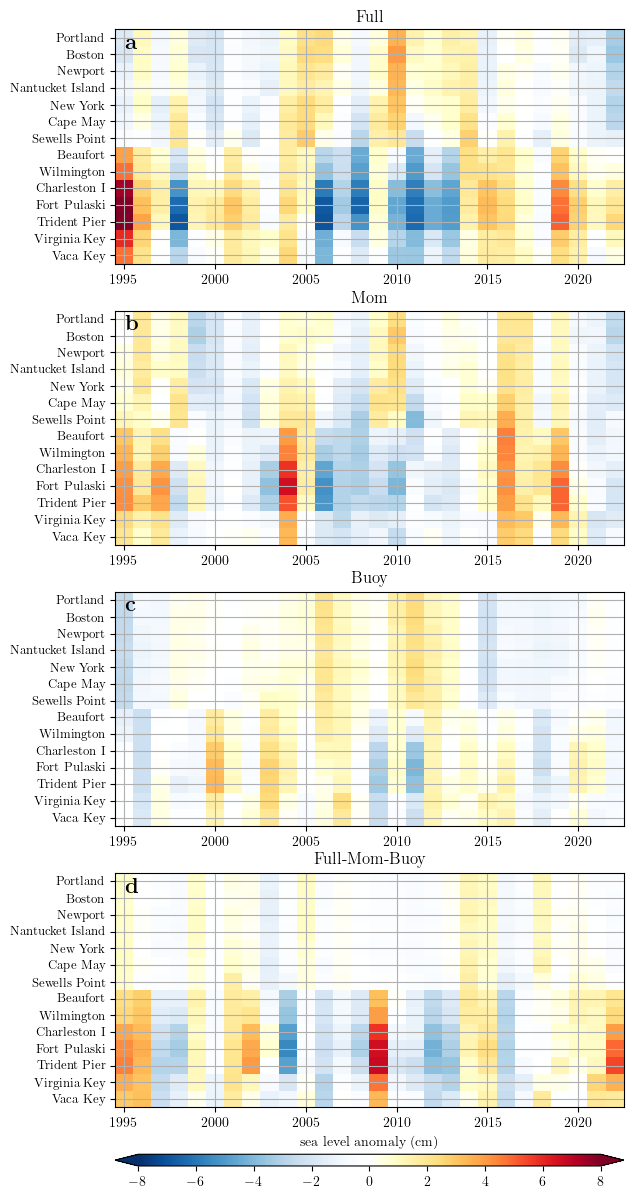

In [97]:
fig = plt.figure(figsize=(10,14))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(4):
    if nsim<1:
        plotvar=hr_tg
        titstr="Full"
    else:
        if nsim<2:
            plotvar=hr_m_tg.T
            titstr="Mom"
        else:
            if nsim<3:
                plotvar=hr_b_tg.T
                titstr="Buoy"
            else:
                plotvar=(hr_tg.T-hr_m_tg-hr_b_tg).T
                titstr="Full-Mom-Buoy"

    ax1 = plt.subplot2grid((4,3), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        lr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    plt.title(titstr)
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)
plt.savefig('USEC_M_B_timeseries.png',
)

## part 3: propagation of SH signal and response of GS.

# Discussion
* potential of offsetting errors at low resolution north of Cape Hatteras.
* overestimated buoyancy-forced sea level changes and overestimated, opposite-signed, momentum-forced sea level changes.
* Results of Li et al. 2022 -- SLR higher north of CH in LR -- perhaps the long term 21st century (presumably buoyancy-forced) response is also overestimated?

In [62]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_b_det.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
ssh['time']=da_alt.time
# ssh=ssh.rename({'nlat':'lat','nlon':'lon'})

dahr=ssh#.groupby('time.year').mean('time').rename({'year':'time'})#

ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_b.nc')
ssh=ssh.ssh.isel(time=slice(24,336+24))
# ssh=ssh.rename({'nlat':'lat','nlon':'lon'})

ssh['time']=da_alt.time
dalr=ssh#.groupby('time.year').mean('time').rename({'year':'time'})

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


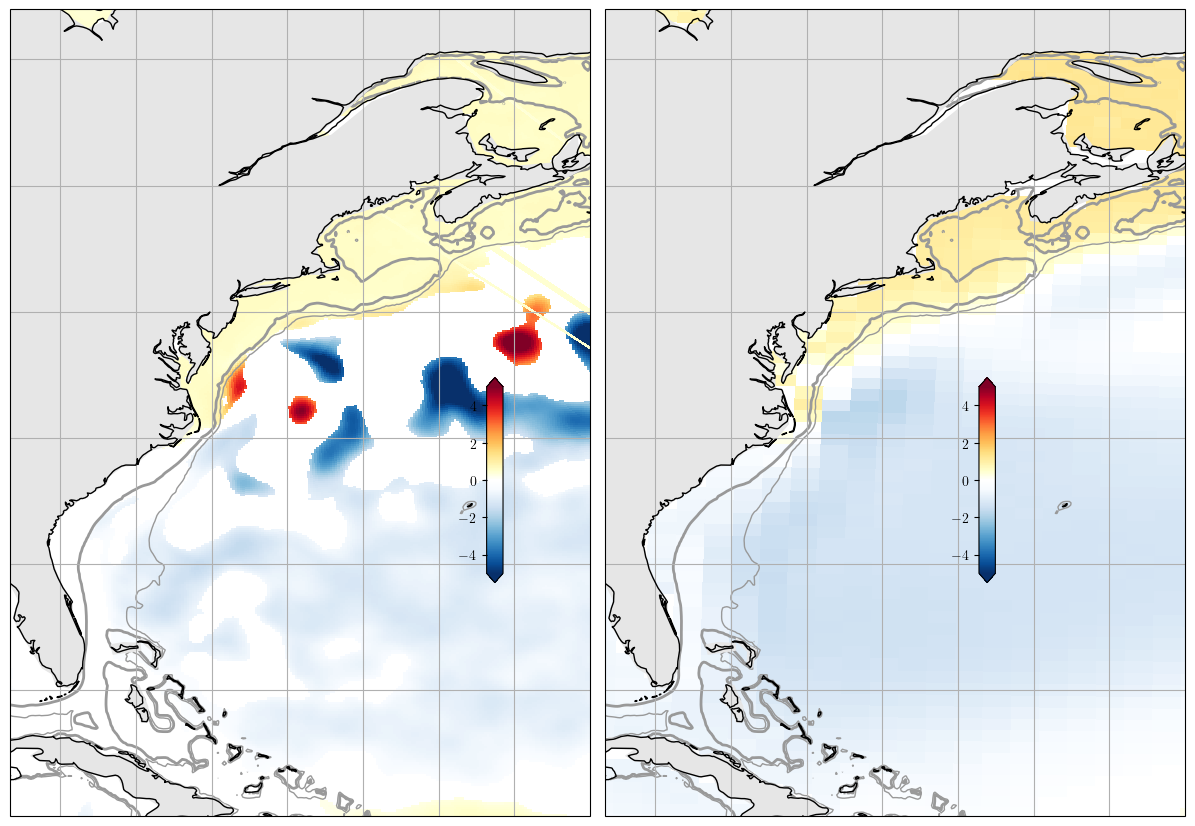

In [63]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, True)

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


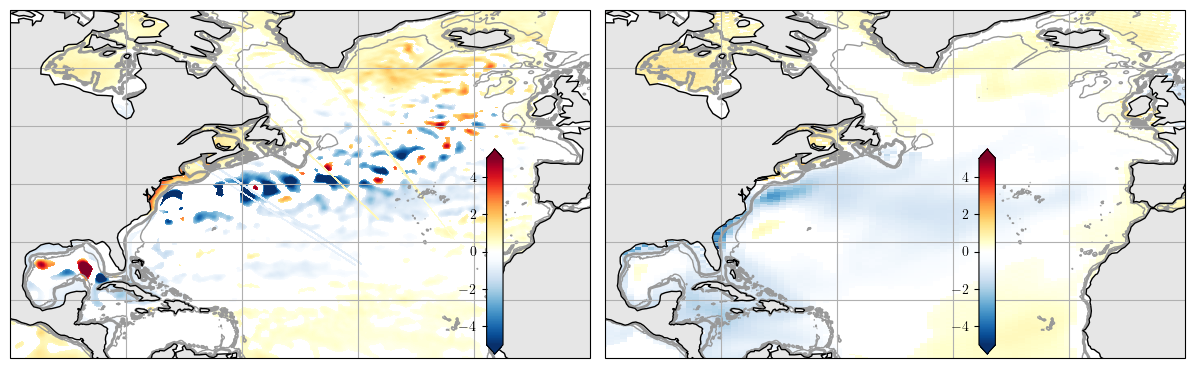

In [168]:
SSHs=[]
pvalc=.05
SSHs.append(da_ann)
SSHs.append(dahr)
SSHs.append(dalr)
plot_ssh_reg2(pcs,SSHs,da.lon,da.lat, 0, False)